In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Dummy Data for Time Series Analysis.csv', index_col=0, parse_dates=True)
df.index.freq = 'M'
df.head()

,Line,Slope,SmallNoice,LargeNoice,Seasonal,SeasonalExpanding,SeasonalIncreasing,SeasonalRandom,RandomA,RandomB,RandomC
1992-11-30,1.0,1,1.172107,8.130815,0.25,0.464011,8.637109,2.879719,-0.265267,-0.456658,0.468067
1992-12-31,1.0,2,2.021540,-3.344672,1.00,1.797734,31.793247,0.250000,0.767685,-0.524471,0.583199
1993-01-31,1.0,3,3.716278,10.965060,2.00,5.672834,63.439086,17.068066,1.247043,-0.903248,0.287193
1993-02-28,1.0,4,4.544567,-2.108747,0.25,0.911308,12.300636,4.525274,1.248169,-2.688179,1.428317
1993-03-31,1.0,5,5.060597,1.480532,1.00,4.082975,35.686083,7.648558,0.183475,-2.436699,0.814009


### Moving Averages

**1- Simple Moving Average**

<AxesSubplot:>

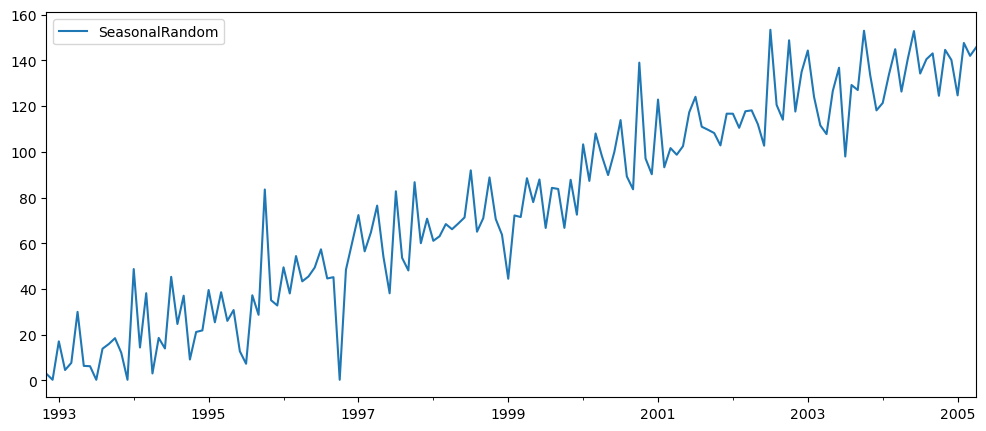

In [3]:
dfMA = df[['SeasonalRandom']]
dfMA.plot(figsize = (12,5))

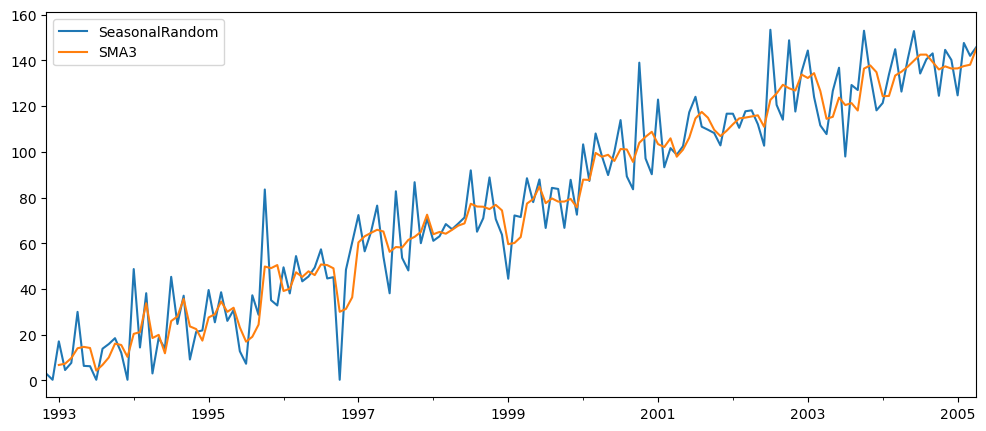

In [4]:
dfMA['SMA3'] = df['SeasonalRandom'].rolling(window = 3).mean()
dfMA.plot(figsize = (12,5));

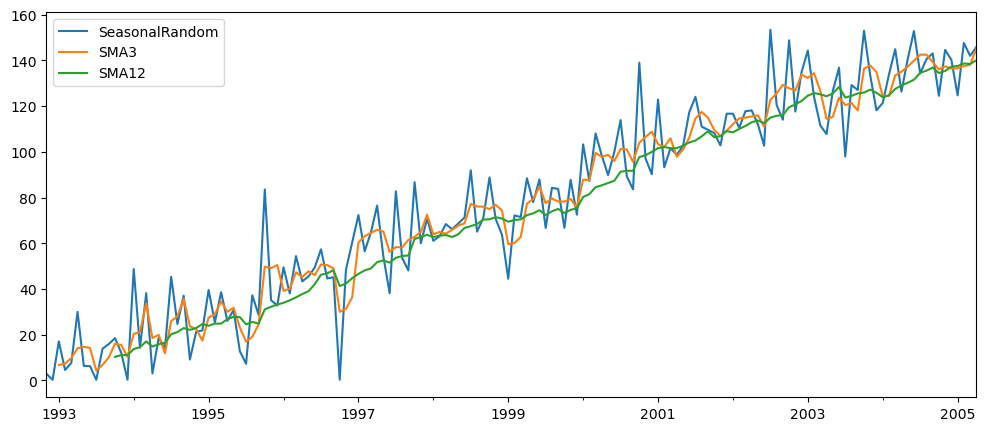

In [5]:
dfMA['SMA12'] = df['SeasonalRandom'].rolling(window = 12).mean()
dfMA.plot(figsize = (12,5));

**2- Exponentially Weighted Moving Average**

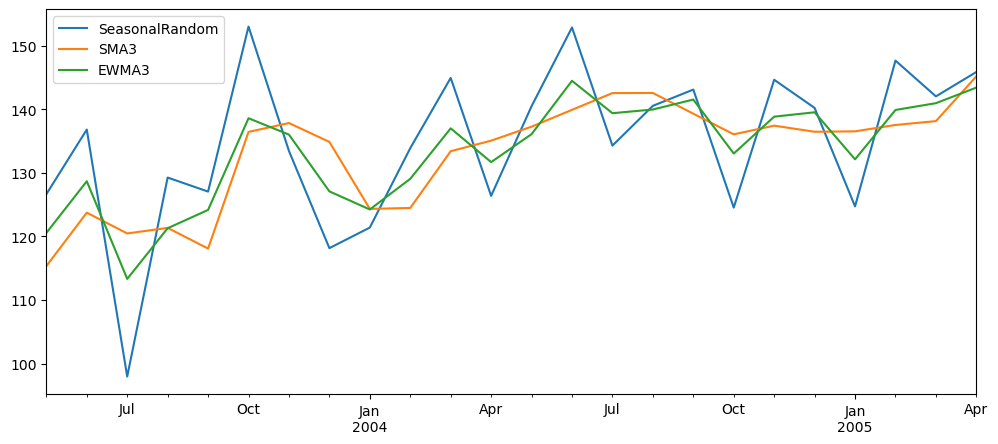

In [6]:
dfMA['EWMA3'] = df['SeasonalRandom'].ewm(span=3,adjust=False).mean()
dfMA.iloc[-24:][['SeasonalRandom','SMA3', 'EWMA3']].plot(figsize = (12,5));

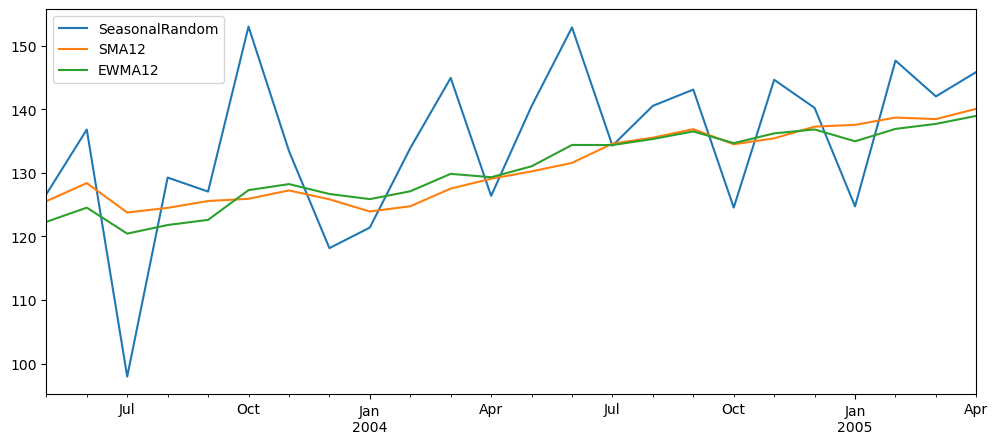

In [7]:
dfMA['EWMA12'] = df['SeasonalRandom'].ewm(span=12,adjust=False).mean()
dfMA.iloc[-24:][['SeasonalRandom','SMA12', 'EWMA12']].plot(figsize = (12,5));

### Error/Trend/Seasonality (ETS) Decomposition

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

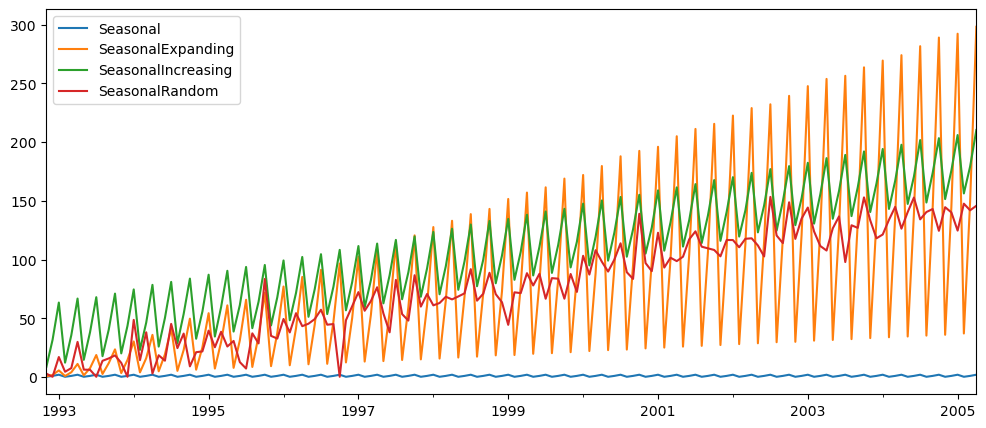

In [9]:
dfSeasonal = df[['Seasonal','SeasonalExpanding','SeasonalIncreasing','SeasonalRandom']]
dfSeasonal.plot(figsize = (12,5));

<AxesSubplot:>

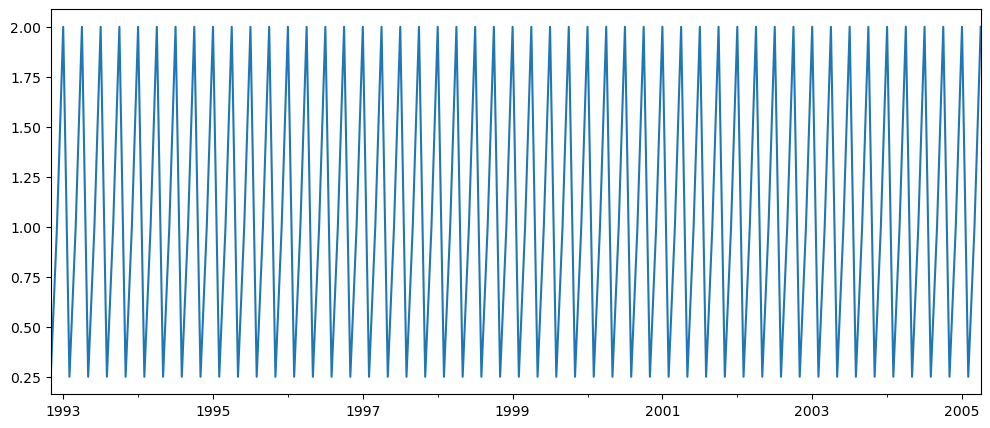

In [10]:
dfSeasonal.Seasonal.plot(figsize = (12,5)) #generated to be strictly seasonal

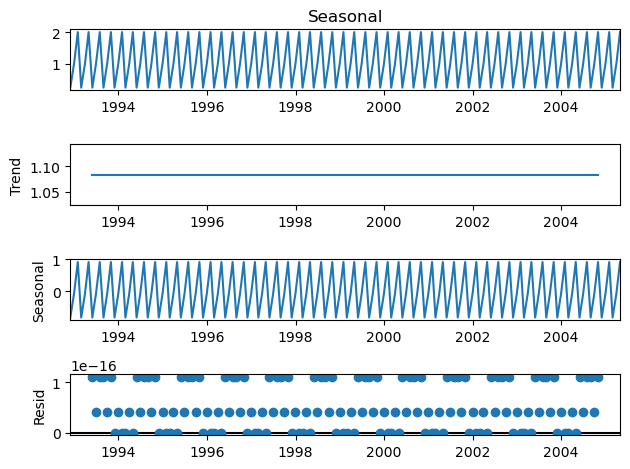

In [11]:
decomposed = seasonal_decompose(dfSeasonal.Seasonal, model='add') #model='mul' also works. Check for the residuals to decide.
decomposed.plot();

<AxesSubplot:>

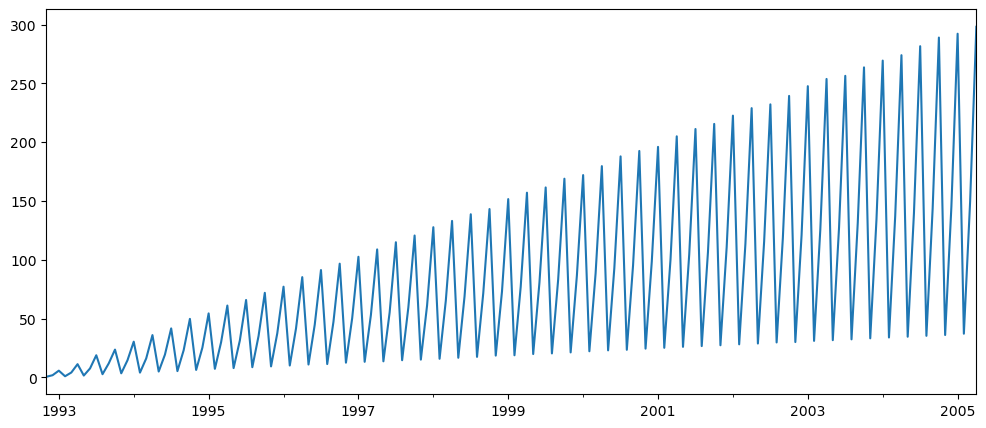

In [12]:
dfSeasonal.SeasonalExpanding.plot(figsize = (12,5)) #generated to be strictly seasonal and expanding

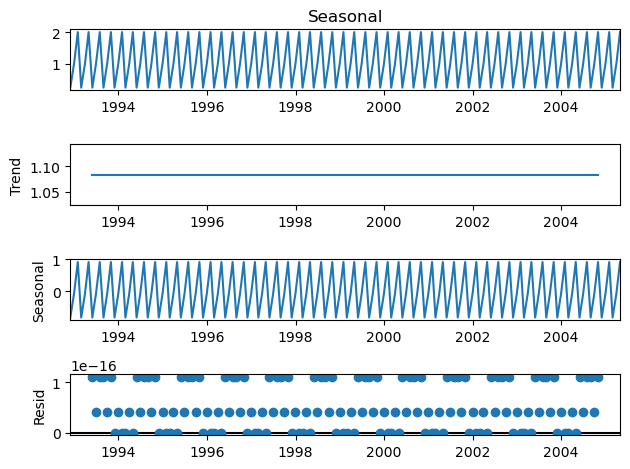

In [13]:
decomposed = seasonal_decompose(dfSeasonal.Seasonal, model='add') #model='mul' also works. Check for the residuals to decide.
decomposed.plot();

<AxesSubplot:>

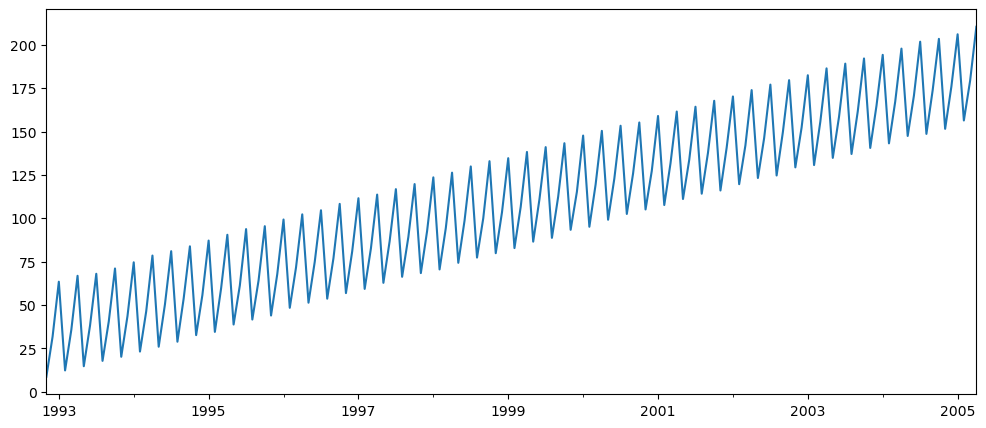

In [14]:
dfSeasonal.SeasonalIncreasing.plot(figsize = (12,5)) #generated to be strictly seasonal and increasing

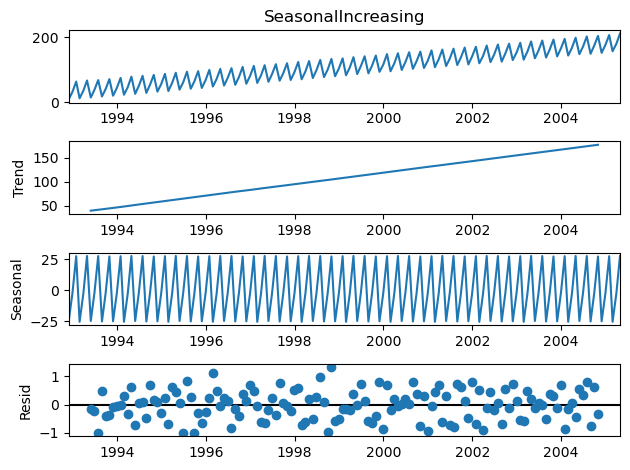

In [15]:
decomposed = seasonal_decompose(dfSeasonal.SeasonalIncreasing, model='add') #model='mul' also works. Check for the residuals to decide.
decomposed.plot();

<AxesSubplot:>

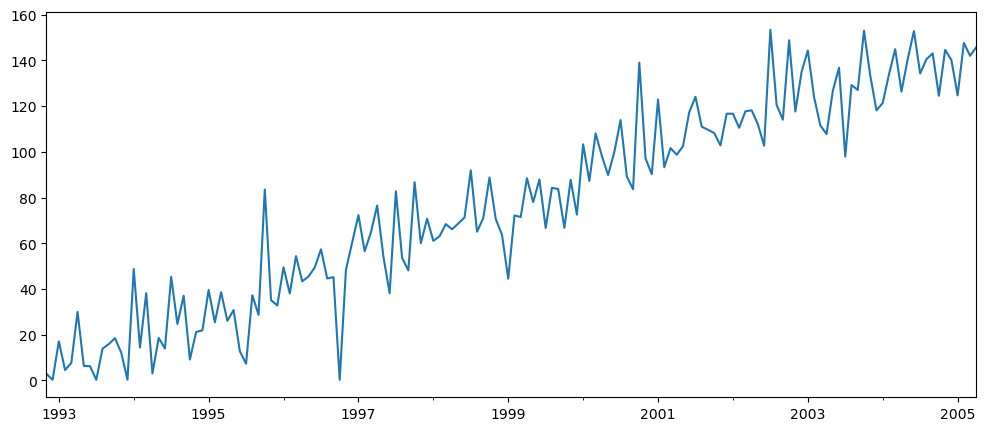

In [16]:
dfSeasonal.SeasonalRandom.plot(figsize = (12,5)) #generated to be slightly seasonal and increasing

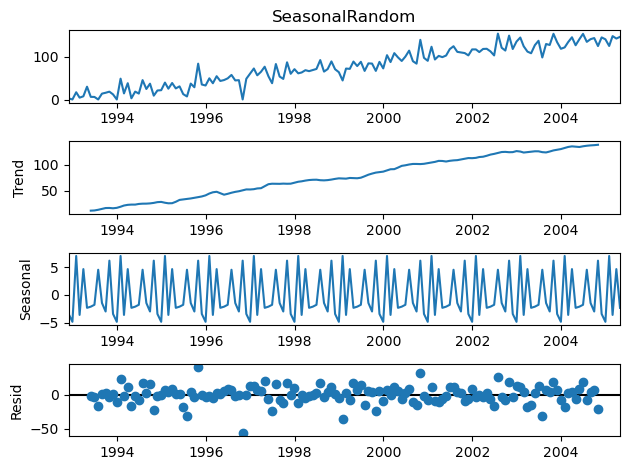

In [17]:
decomposed = seasonal_decompose(dfSeasonal.SeasonalRandom, model='add') #model='mul' also works. Check for the residuals to decide.
decomposed.plot();

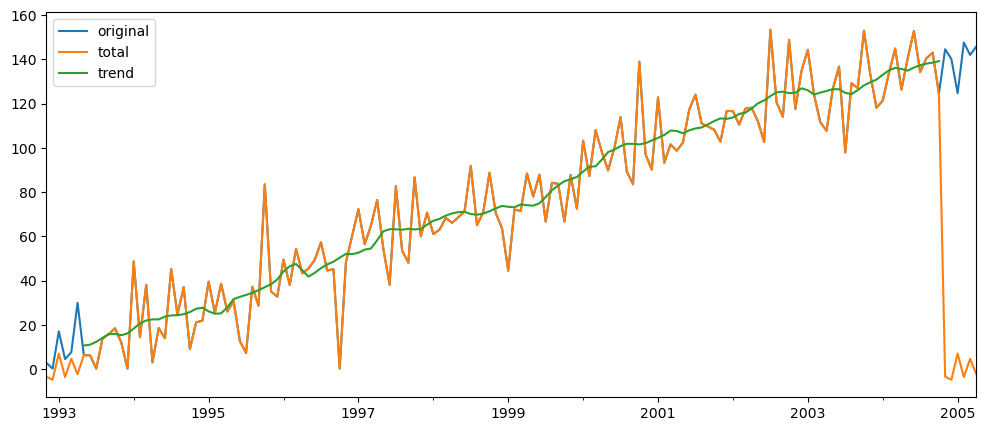

In [18]:
decomposedDf = pd.DataFrame()

decomposedDf['residual'] = decomposed.resid
decomposedDf['seasonal'] = decomposed.seasonal
decomposedDf['trend']    = decomposed.trend 
decomposedDf['total']    = decomposed.resid.fillna(0) + decomposed.seasonal.fillna(0) + decomposed.trend.fillna(0)
decomposedDf['original'] = dfSeasonal.SeasonalRandom

decomposedDf[['original','total','trend']].plot(figsize = (12,5));

### Hodrick-Prescott Filter

In [19]:
from statsmodels.tsa.filters.hp_filter import hpfilter

<AxesSubplot:>

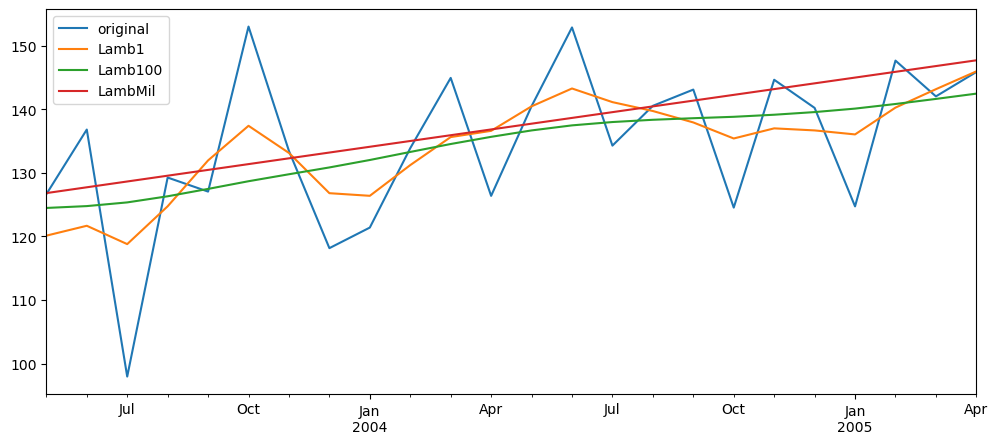

In [20]:
hpcycle1, hptrend1     = hpfilter(dfSeasonal.SeasonalRandom, lamb=1)
hpcycle100, hptrend100 = hpfilter(dfSeasonal.SeasonalRandom, lamb=100)
hpcycleMil, hptrendMil = hpfilter(dfSeasonal.SeasonalRandom, lamb=1000000)

hpDF = pd.DataFrame()
hpDF['original'] = dfSeasonal.SeasonalRandom
hpDF['Lamb1']    = hptrend1
hpDF['Lamb100']  = hptrend100
hpDF['LambMil']  = hptrendMil

hpDF.iloc[-24:].plot(figsize = (12,5))

### Holt-Winters Methods

**1- Simple Exponential Smoothing**

Exponentially Weighted Moving Average is a variation of the Holt-Winters Simple Exponential Smoothing function.

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [22]:
span = 12
alpha = 2/(span+1)

dfMA['SES12'] = SimpleExpSmoothing(df.SeasonalRandom).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfMA.head() 

,SeasonalRandom,SMA3,SMA12,EWMA3,EWMA12,SES12
1992-11-30,2.879719,NaN,NaN,2.879719,2.879719,2.879719
1992-12-31,0.250000,NaN,NaN,1.564859,2.475147,2.475147
1993-01-31,17.068066,6.732595,NaN,9.316462,4.720211,4.720211
1993-02-28,4.525274,7.281113,NaN,6.920868,4.690221,4.690221
1993-03-31,7.648558,9.747299,NaN,7.284713,5.145350,5.145350


**2- Double Exponential Smoothing**

When using Holt-Winters Methods, the “trend” parameter should be adjusted according to the types of changes in the trend of a time series. If a time series shows a straight-line sloping trend, we should use an "additional" adjustment. If the time series shows an exponential (curved) trend, we should use an "multiplicative" adjustment.

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [24]:
dfMA['DES12add'] = ExponentialSmoothing(df.SeasonalRandom, trend='add').fit().fittedvalues.shift(-1)
dfMA.head()

,SeasonalRandom,SMA3,SMA12,EWMA3,EWMA12,SES12,DES12add
1992-11-30,2.879719,NaN,NaN,2.879719,2.879719,2.879719,5.991860
1992-12-31,0.250000,NaN,NaN,1.564859,2.475147,2.475147,6.960327
1993-01-31,17.068066,6.732595,NaN,9.316462,4.720211,4.720211,7.928794
1993-02-28,4.525274,7.281113,NaN,6.920868,4.690221,4.690221,8.897260
1993-03-31,7.648558,9.747299,NaN,7.284713,5.145350,5.145350,9.865727


<AxesSubplot:>

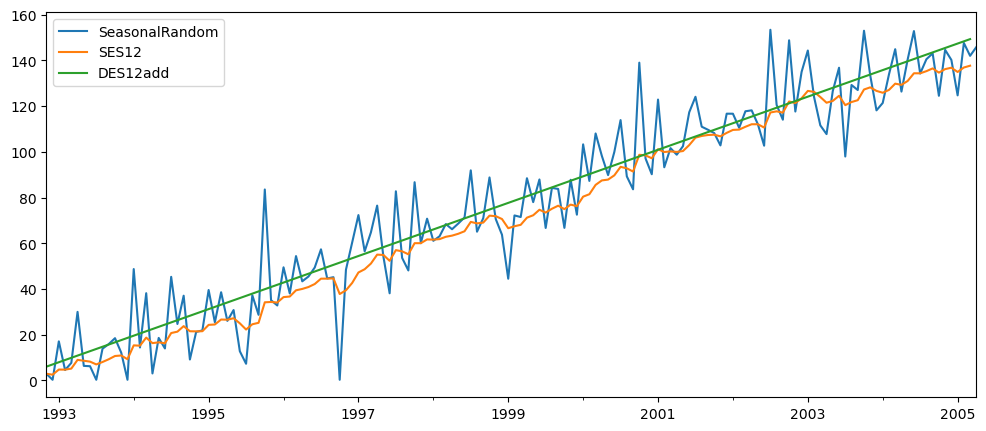

In [25]:
dfMA[['SeasonalRandom','SES12','DES12add']].plot(figsize = (12,5))

<AxesSubplot:>

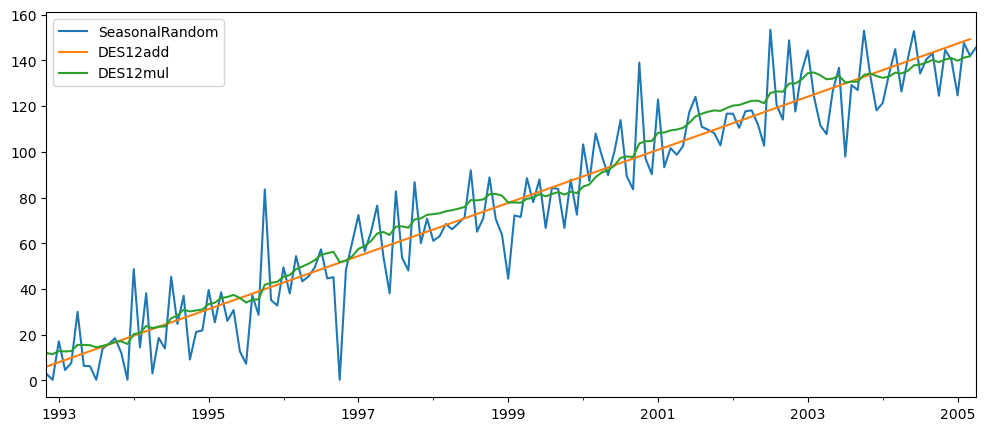

In [26]:
dfMA['DES12mul'] = ExponentialSmoothing(df.SeasonalRandom, trend='mul').fit().fittedvalues.shift(-1)
dfMA[['SeasonalRandom','DES12add','DES12mul']].plot(figsize = (12,5))

**3- Triple Exponential Smoothing**

Triple Exponential Smoothing also adds seasonality into account. I will use this one on strictly seasonal data too.

<AxesSubplot:>

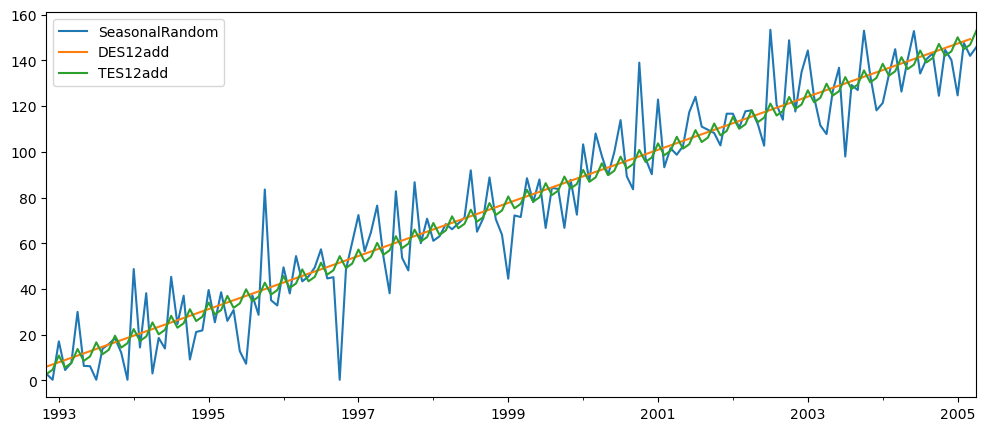

In [27]:
dfMA['TES12add'] = ExponentialSmoothing(df.SeasonalRandom, trend='add',seasonal='add',seasonal_periods=3).fit().fittedvalues
dfMA[['SeasonalRandom','DES12add','TES12add']].plot(figsize = (12,5))

<AxesSubplot:>

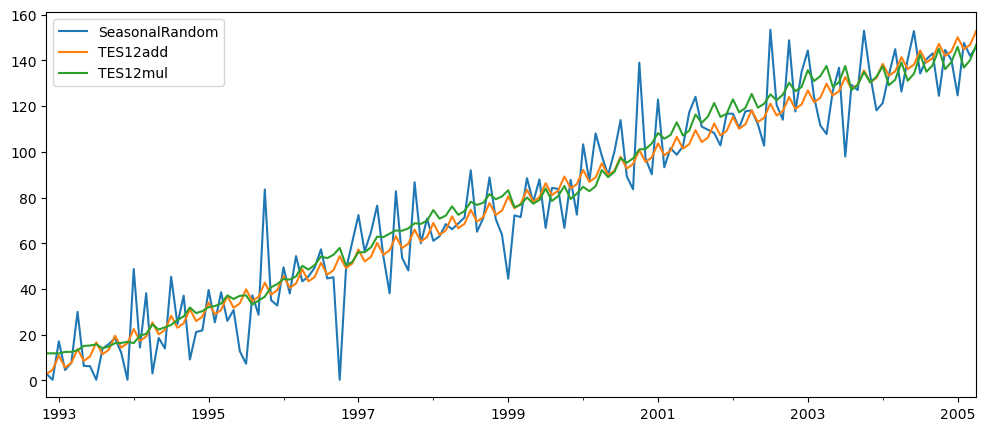

In [28]:
dfMA['TES12mul'] = ExponentialSmoothing(df.SeasonalRandom, trend='mul',seasonal='mul',seasonal_periods=3).fit().fittedvalues
dfMA[['SeasonalRandom','TES12add', 'TES12mul']].plot(figsize = (12,5))

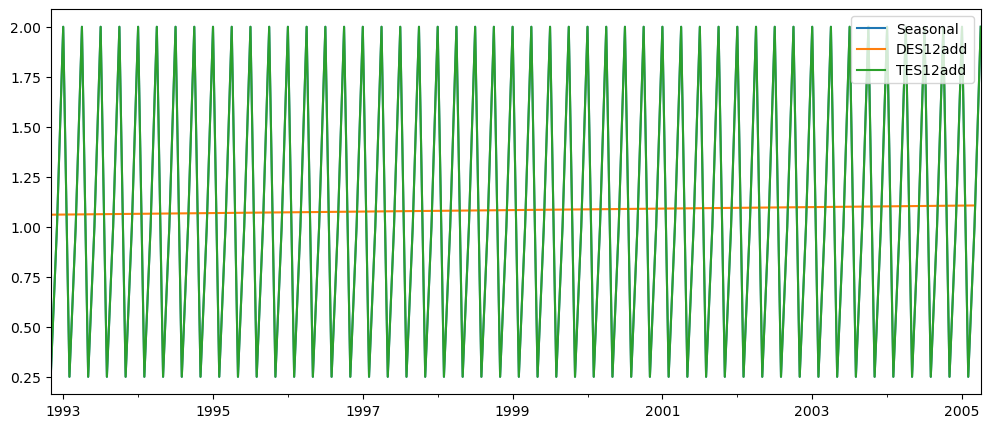

In [29]:
newDf = dfSeasonal[['Seasonal', 'SeasonalIncreasing', 'SeasonalExpanding']]

newDf['DES12add'] = ExponentialSmoothing(newDf.Seasonal, trend='add').fit().fittedvalues.shift(-1)
newDf['TES12add'] = ExponentialSmoothing(newDf.Seasonal, trend='add',seasonal='add',seasonal_periods=3).fit().fittedvalues
newDf[['Seasonal','DES12add','TES12add']].plot(figsize = (12,5));

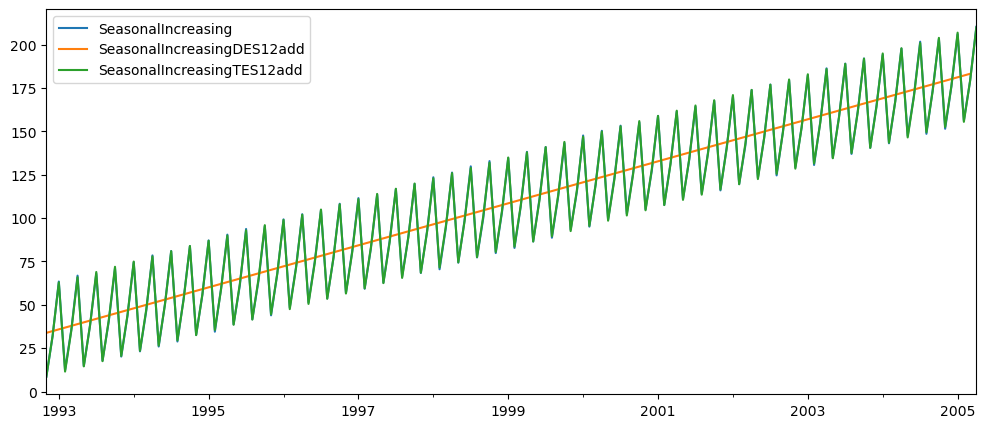

In [30]:
newDf['SeasonalIncreasingDES12add'] = ExponentialSmoothing(newDf.SeasonalIncreasing, trend='add').fit().fittedvalues.shift(-1)
newDf['SeasonalIncreasingTES12add'] = ExponentialSmoothing(newDf.SeasonalIncreasing, trend='add',seasonal='add',seasonal_periods=3).fit().fittedvalues
newDf[['SeasonalIncreasing','SeasonalIncreasingDES12add','SeasonalIncreasingTES12add']].plot(figsize = (12,5));

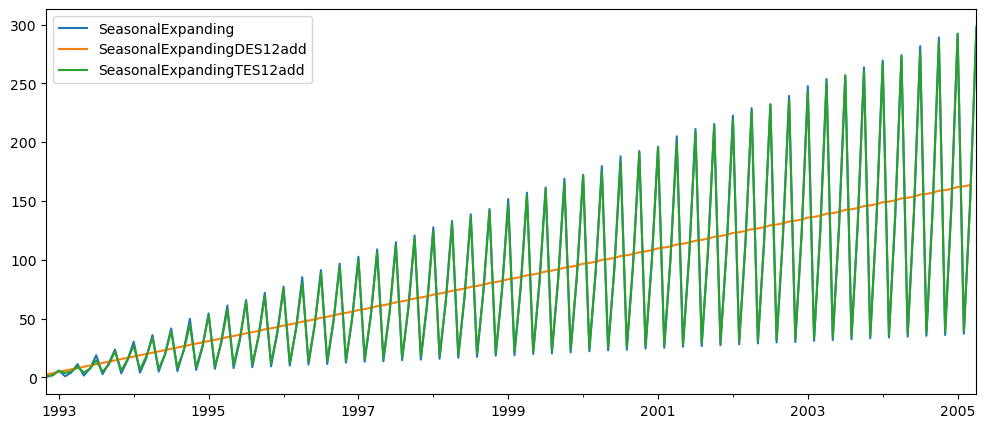

In [31]:
newDf['SeasonalExpandingDES12add'] = ExponentialSmoothing(newDf.SeasonalExpanding, trend='add').fit().fittedvalues.shift(-1)
newDf['SeasonalExpandingTES12add'] = ExponentialSmoothing(newDf.SeasonalExpanding, trend='add',seasonal='add',seasonal_periods=3).fit().fittedvalues
newDf[['SeasonalExpanding','SeasonalExpandingDES12add','SeasonalExpandingTES12add']].plot(figsize = (12,5));

### Month and Quarter Plots

In [32]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

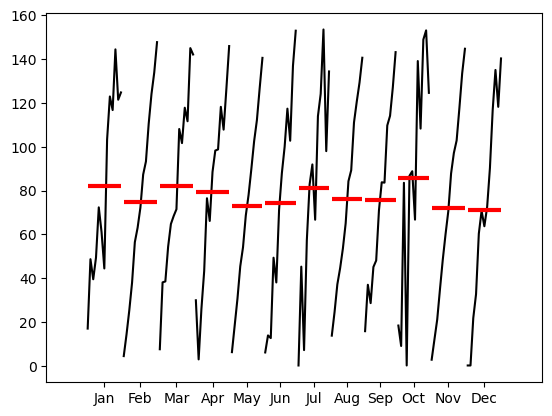

In [33]:
month_plot(df['SeasonalRandom']);

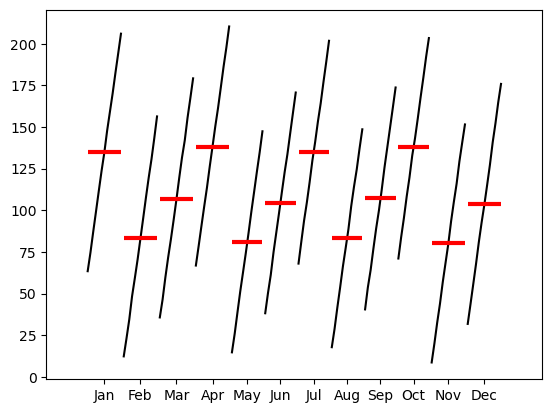

In [34]:
month_plot(df['SeasonalIncreasing']);

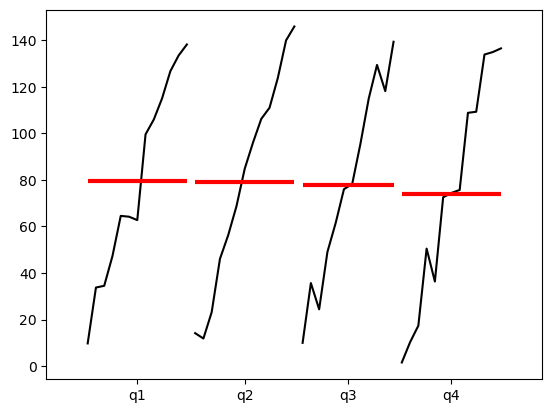

In [35]:
qtDataRandom = df['SeasonalRandom'].resample(rule = 'Q').mean().dropna()
qtDataRandom.index.freq = 'Q'
quarter_plot(qtDataRandom);